In [1]:
pip install tensorflow==2.17.1 keras==3.5.0

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
print(tf.__version__)

2.17.1


In [4]:
# Konfigurasi dataset
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10
NUM_CLASSES = 54

In [5]:
# Load dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    'dataset/train',
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int',
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    'dataset/validation',
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int',
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    'dataset/test',
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int',
    shuffle=False
)

class_names = test_ds.class_names

Found 8478 files belonging to 54 classes.
Found 1782 files belonging to 54 classes.
Found 1782 files belonging to 54 classes.


In [6]:
for images, labels in train_ds.take(1):
    print("Image dtype:", images.dtype)
    print("Label dtype:", labels.dtype)

Image dtype: <dtype: 'float32'>
Label dtype: <dtype: 'int32'>


In [7]:
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.1),
    layers.RandomTranslation(0.15, 0.15),
    layers.RandomZoom(0.2),
    layers.RandomFlip('horizontal')
])

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, augment=False):
  # Normalization all datasets.
  ds = ds.map(lambda x, y: (x, y), 
              num_parallel_calls=AUTOTUNE)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [9]:
train_ds = prepare(train_ds, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

In [10]:
base_model = MobileNetV3Large(input_shape=(224, 224, 3), weights='imagenet', include_top=False, include_preprocessing=True)
base_model.trainable = False

In [11]:
model = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Large (Functional)   │ (None, 7, 7, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       246,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 54)             │        13,878 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,257,270 (12.43 MB)

 Trainable params: 260,406 (1017.21 KB)

 Non-trainable params: 2,996,864 (11.43 MB)

In [12]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
history = model.fit(
      train_ds,
      epochs=EPOCHS,
      verbose=2,
      validation_data=val_ds)

Epoch 1/10
265/265 - 29s - 110ms/step - accuracy: 0.6759 - loss: 1.2857 - val_accuracy: 0.9394 - val_loss: 0.2345
Epoch 2/10
265/265 - 26s - 98ms/step - accuracy: 0.8892 - loss: 0.4110 - val_accuracy: 0.9512 - val_loss: 0.1803
Epoch 3/10
265/265 - 26s - 98ms/step - accuracy: 0.9271 - loss: 0.2670 - val_accuracy: 0.9585 - val_loss: 0.1438
Epoch 4/10
265/265 - 26s - 99ms/step - accuracy: 0.9331 - loss: 0.2329 - val_accuracy: 0.9652 - val_loss: 0.1204
Epoch 5/10
265/265 - 26s - 98ms/step - accuracy: 0.9461 - loss: 0.1867 - val_accuracy: 0.9658 - val_loss: 0.1214
Epoch 6/10
265/265 - 26s - 99ms/step - accuracy: 0.9474 - loss: 0.1823 - val_accuracy: 0.9618 - val_loss: 0.1274
Epoch 7/10
265/265 - 26s - 99ms/step - accuracy: 0.9529 - loss: 0.1573 - val_accuracy: 0.9691 - val_loss: 0.0885
Epoch 8/10
265/265 - 27s - 100ms/step - accuracy: 0.9575 - loss: 0.1466 - val_accuracy: 0.9641 - val_loss: 0.1241
Epoch 9/10
265/265 - 27s - 100ms/step - accuracy: 0.9575 - loss: 0.1341 - val_accuracy: 0.9663

In [14]:
results = pd.DataFrame(history.history)
print(results)

   accuracy      loss  val_accuracy  val_loss
0  0.675867  1.285683      0.939394  0.234527
1  0.889243  0.411008      0.951178  0.180308
2  0.927105  0.266993      0.958474  0.143847
3  0.933121  0.232929      0.965208  0.120409
4  0.946096  0.186668      0.965769  0.121352
5  0.947393  0.182279      0.961841  0.127437
6  0.952937  0.157303      0.969136  0.088533
7  0.957537  0.146601      0.964085  0.124110
8  0.957537  0.134094      0.966330  0.107888
9  0.965912  0.121595      0.968575  0.100499


In [15]:
model.evaluate(test_ds, verbose=2)

56/56 - 4s - 80ms/step - accuracy: 0.9675 - loss: 0.1092


[0.10920766741037369, 0.9674522876739502]

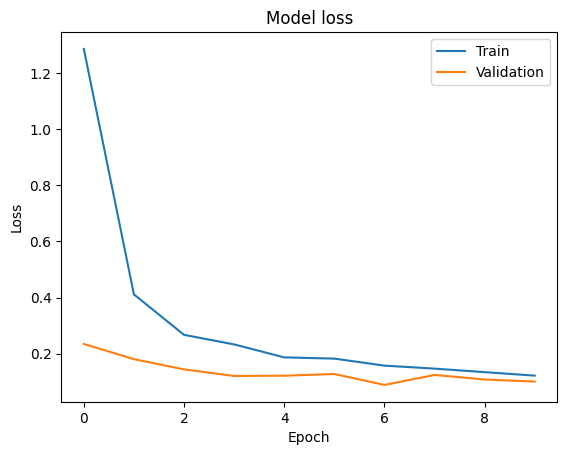

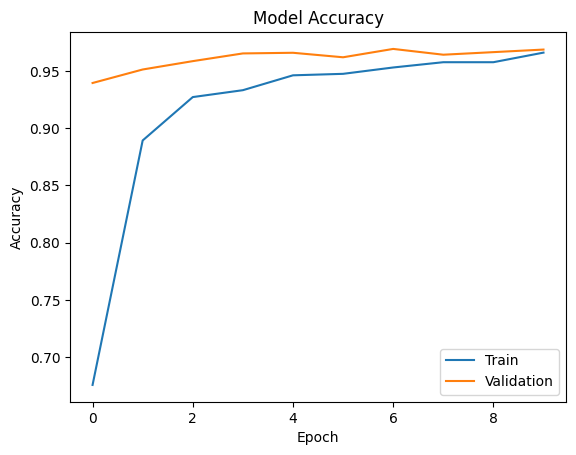

In [16]:
# Plotting the training and testing loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plotting the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

56/56 - 5s - 98ms/step


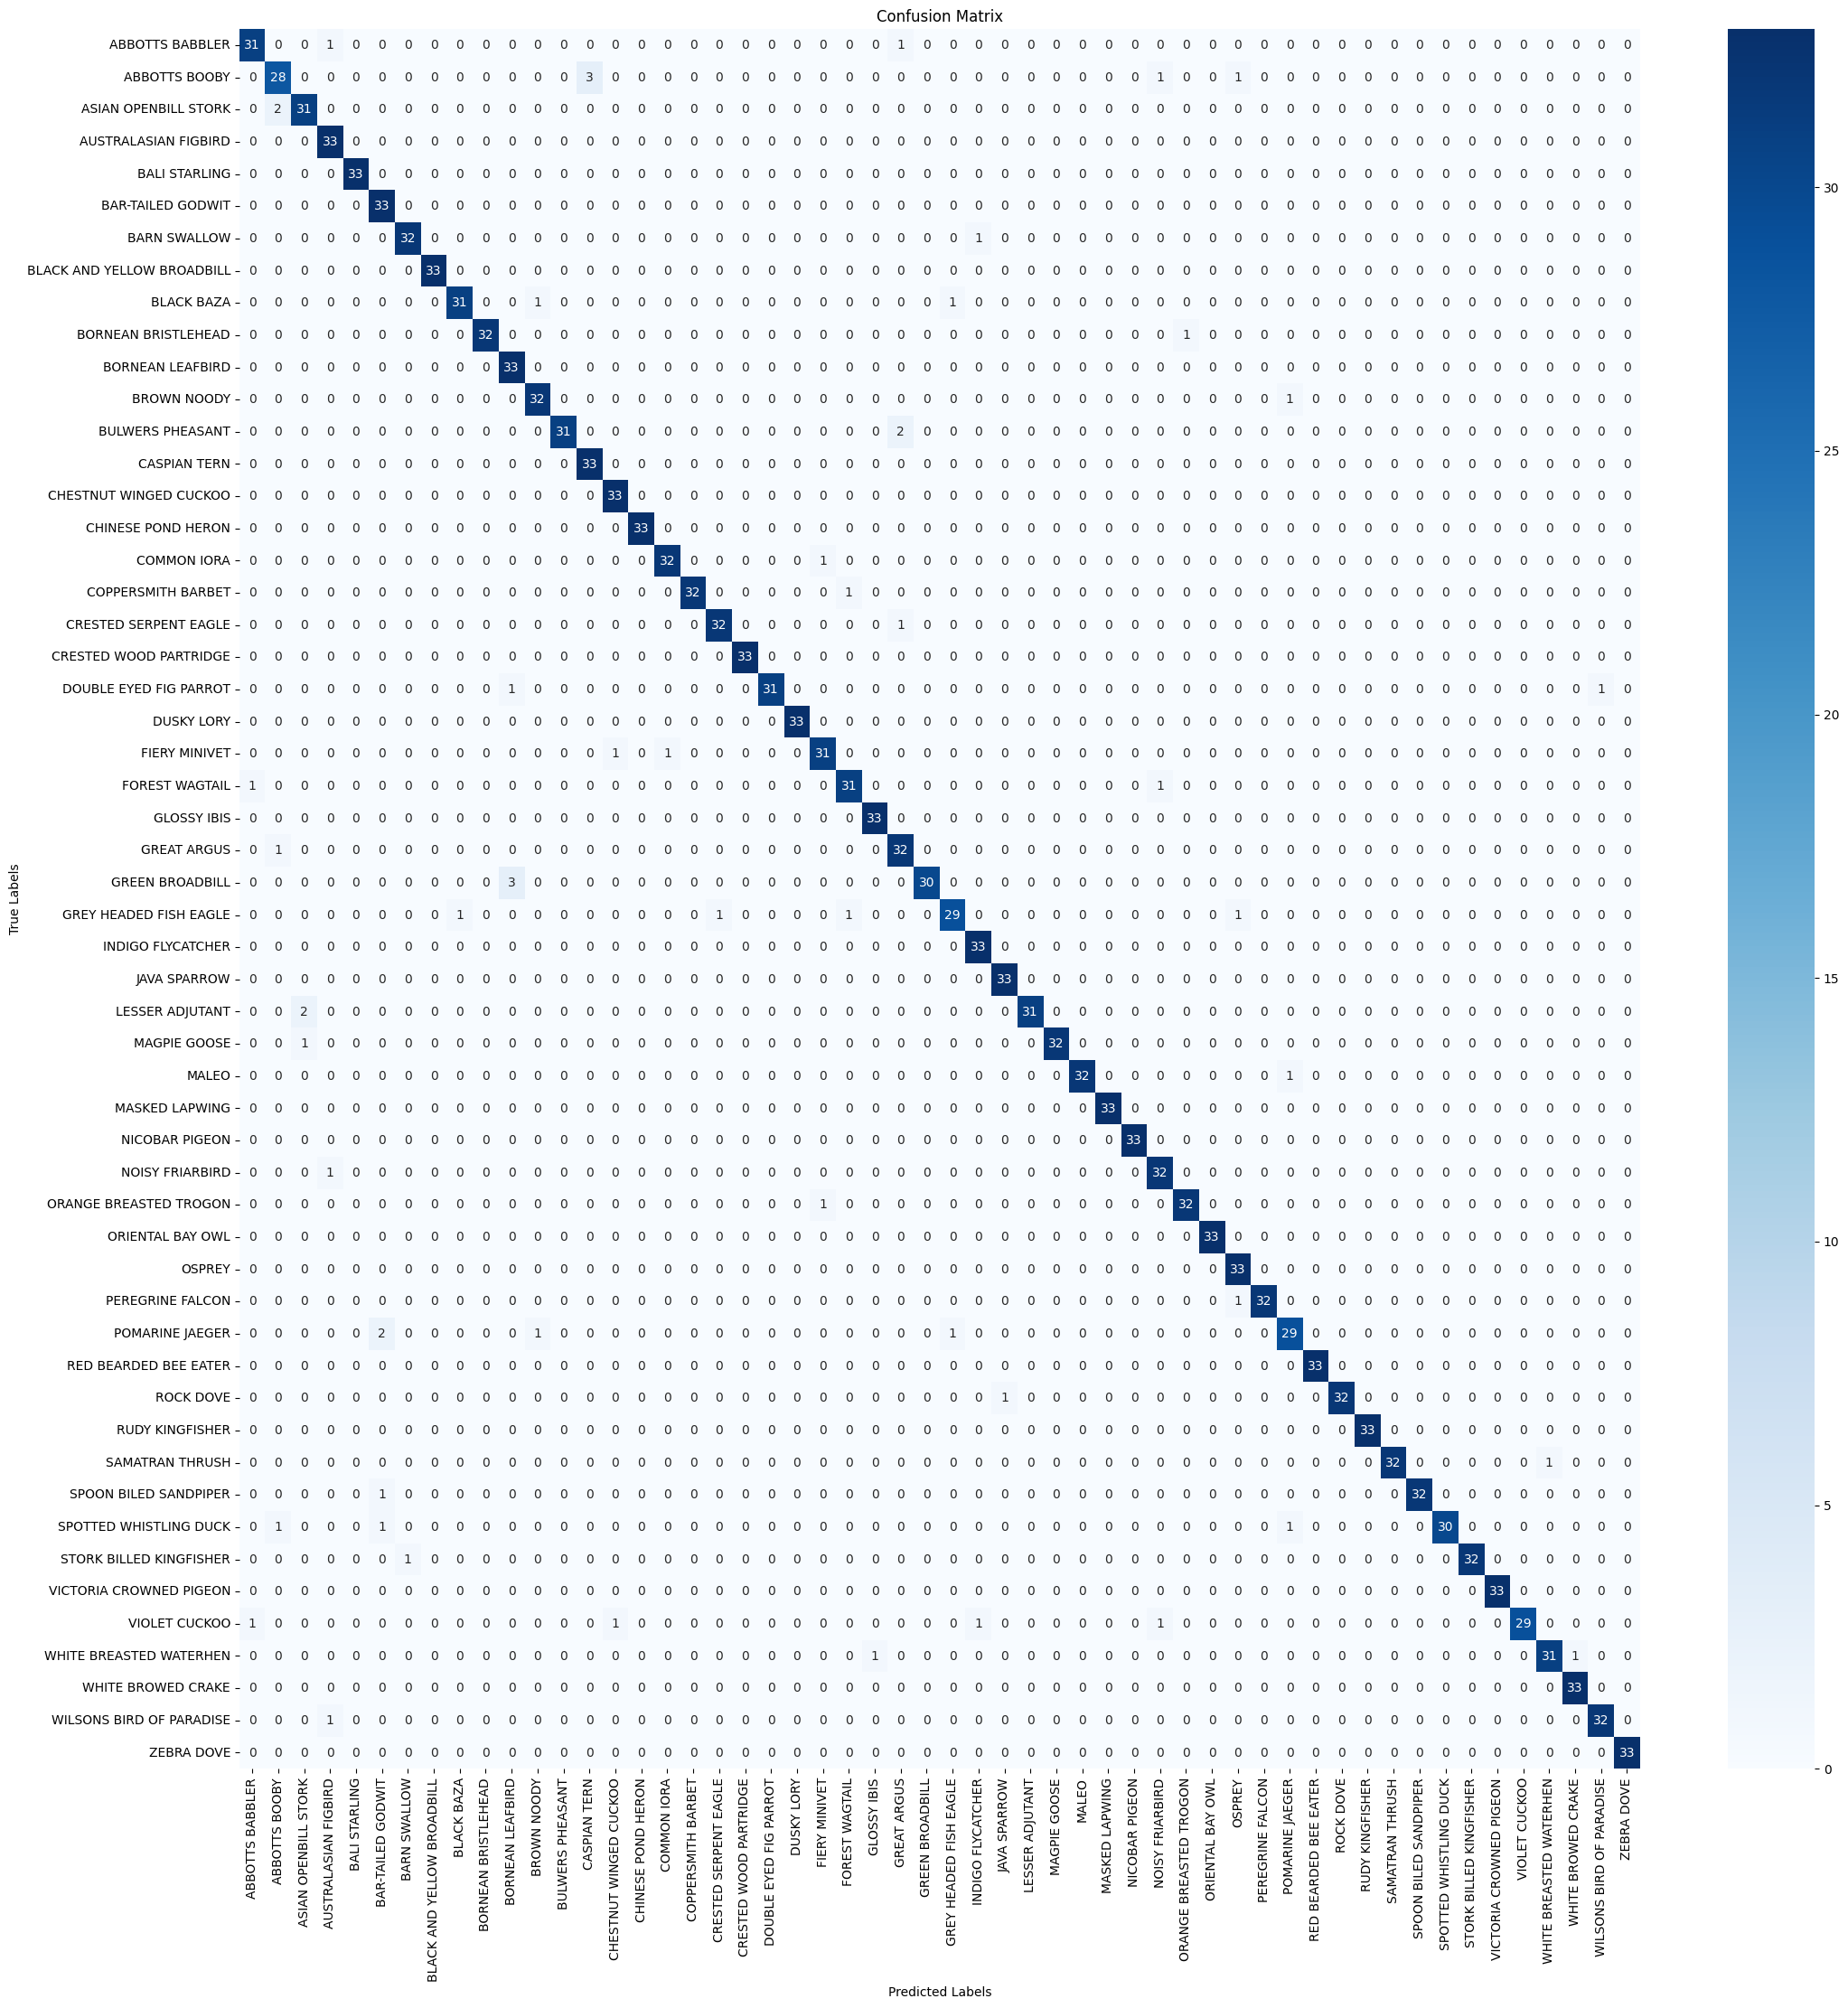

In [17]:
# Confusion matrix dan classification report
true_labels = np.concatenate([y.numpy() for x, y in test_ds])
y_pred_probs = model.predict(test_ds, verbose=2)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(true_labels, y_pred_labels)

plt.figure(figsize=(25, 25))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [18]:
print('Classification Report:')
print(classification_report(true_labels, y_pred_labels, target_names=class_names))

Classification Report:
                            precision    recall  f1-score   support

           ABBOTTS BABBLER       0.94      0.94      0.94        33
             ABBOTTS BOOBY       0.88      0.85      0.86        33
      ASIAN OPENBILL STORK       0.91      0.94      0.93        33
      AUSTRALASIAN FIGBIRD       0.92      1.00      0.96        33
             BALI STARLING       1.00      1.00      1.00        33
         BAR-TAILED GODWIT       0.89      1.00      0.94        33
              BARN SWALLOW       0.97      0.97      0.97        33
BLACK AND YELLOW BROADBILL       1.00      1.00      1.00        33
                BLACK BAZA       0.97      0.94      0.95        33
       BORNEAN BRISTLEHEAD       1.00      0.97      0.98        33
          BORNEAN LEAFBIRD       0.89      1.00      0.94        33
               BROWN NOODY       0.94      0.97      0.96        33
          BULWERS PHEASANT       1.00      0.94      0.97        33
              CASPIAN TE

In [19]:
# Confusion matrix
cm = confusion_matrix(true_labels, y_pred_labels)
labels = class_names  # list nama kelas
results = []

# Inisialisasi untuk rata-rata
total_accuracy = 0
total_precision = 0
total_recall = 0
total_f1 = 0
total_test_data = 0

# Hitung metrik per kelas
for i, label in enumerate(labels):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)

    total = TP + FN
    total_test_data += total

    # Hitung metrik
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Akumulasi untuk rata-rata
    total_precision += precision
    total_recall += recall
    total_f1 += f1_score

    results.append({
        'Class': label,
        'Total': total,
        'TP': TP,
        'FP': FP,
        'FN': FN,
        'TN': TN,
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'F1-Score': round(f1_score, 4)
    })

# Hitung rata-rata
n_classes = len(labels)
avg_precision = total_precision / n_classes
avg_recall = total_recall / n_classes
avg_f1 = total_f1 / n_classes

# Tambahkan baris rata-rata ke DataFrame
results.append({
    'Class': 'Average',
    'Total': total_test_data,
    'TP': '-',
    'FP': '-',
    'FN': '-',
    'TN': '-',
    'Precision': round(avg_precision, 4),
    'Recall': round(avg_recall, 4),
    'F1-Score': round(avg_f1, 4)
})

# Buat DataFrame
metrics_df = pd.DataFrame(results)
metrics_df.to_excel('hasilmodel/cnn+mobilenet/large/confusion_metrics_mobilenetv3large.xlsx', index=False)

In [20]:
# Confusion matrix
cm = confusion_matrix(true_labels, y_pred_labels)

# Inisialisasi list untuk hasil
labels = class_names
results = []

# Hitung TP, FP, FN, TN untuk setiap kelas
for i, label in enumerate(labels):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)
    results.append({
        'Class': label,
        'TP': TP,
        'FP': FP,
        'FN': FN,
        'TN': TN
    })

# Buat dataframe
metrics_df = pd.DataFrame(results)

# Tampilkan tabel
print(metrics_df)

metrics_df.to_excel('hasilmodel/cnn+mobilenet/large/tidaklengkapconfusion_metrics_mobilenetv3large.xlsx', index=False)

                         Class  TP  FP  FN    TN
0              ABBOTTS BABBLER  31   2   2  1747
1                ABBOTTS BOOBY  28   4   5  1745
2         ASIAN OPENBILL STORK  31   3   2  1746
3         AUSTRALASIAN FIGBIRD  33   3   0  1746
4                BALI STARLING  33   0   0  1749
5            BAR-TAILED GODWIT  33   4   0  1745
6                 BARN SWALLOW  32   1   1  1748
7   BLACK AND YELLOW BROADBILL  33   0   0  1749
8                   BLACK BAZA  31   1   2  1748
9          BORNEAN BRISTLEHEAD  32   0   1  1749
10            BORNEAN LEAFBIRD  33   4   0  1745
11                 BROWN NOODY  32   2   1  1747
12            BULWERS PHEASANT  31   0   2  1749
13                CASPIAN TERN  33   3   0  1746
14      CHESTNUT WINGED CUCKOO  33   2   0  1747
15          CHINESE POND HERON  33   0   0  1749
16                 COMMON IORA  32   1   1  1748
17          COPPERSMITH BARBET  32   0   1  1749
18       CRESTED SERPENT EAGLE  32   1   1  1748
19      CRESTED WOOD

In [21]:
model.save('hasilmodel/cnn+mobilenet/large/mobilenetv3large.keras')

In [22]:
# Ambil nama folder dalam dataset/train sebagai label
class_names = sorted(os.listdir('dataset/train'))

# Simpan label ke dalam file labels.txt
with open('hasilmodel/cnn+mobilenet/large/labelslarge.txt', 'w') as f:
    for label in class_names:
        f.write(f'{label}\n')

print('Label mapping saved to labelslarge.txt')

Label mapping saved to labelslarge.txt
